In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
DIM = 256

In [ ]:
class DataImg(Dataset):
    def __init__(self, transform):
        self.train_sketches = sorted(glob.glob('drive/MyDrive/dataset/training_i/cropped_sketches/*.jpg'))
        self.train_photos = sorted(glob.glob('drive/MyDrive/dataset/training_ii/cropped_photos/*.jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.train_sketches)

    def __getitem__(self, idx):
        return (self.transform(Image.open(self.train_sketches[idx]).resize((DIM, DIM))), self.transform(Image.open(self.train_photos[idx]).resize((DIM, DIM))))


In [ ]:
train_data = DataImg(transform = torchvision.transforms.ToTensor())
train_dataloader = DataLoader(train_data, batch_size=4, num_workers=0)

In [ ]:
def sample(kernel, c_in, c_out, dropout):
    layers = list()
    layers.append(kernel(c_in, c_out, kernel_size=4, stride=2, padding=1))
    layers.append(nn.BatchNorm2d(num_features=c_out))
    if dropout:
        layers.append(nn.Dropout())
    layers.append(nn.LeakyReLU())
    return nn.Sequential(*layers)

In [ ]:
class Generator(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.generator = nn.Sequential(
            # Downsample
            sample(nn.Conv2d, 1, 64,dropout=False),  
            sample(nn.Conv2d, 64, 128,dropout=False),               
            sample(nn.Conv2d, 128, DIM,dropout=False),                
            sample(nn.Conv2d, DIM, DIM, dropout=True),   
            sample(nn.Conv2d, DIM, DIM, dropout=True),  

            # Upsample
            sample(nn.ConvTranspose2d, DIM, DIM, dropout=True), 
            sample(nn.ConvTranspose2d, DIM, DIM,dropout=False),       
            sample(nn.ConvTranspose2d, DIM, 128,dropout=False),    
            sample(nn.ConvTranspose2d, 128, 64,dropout=False),    
            sample(nn.ConvTranspose2d, 64, 3,dropout=False),  
        )

    def forward(self, img_in):
        return self.generator(img_in)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.discriminator = nn.Sequential(
            sample(nn.Conv2d, 4, 64,dropout=False),                             
            sample(nn.Conv2d, 64, 128,dropout=False),                    
            sample(nn.Conv2d, 128, DIM,dropout=False),                
            nn.Conv2d(DIM, 128, kernel_size=4, padding=1), 
            nn.LeakyReLU(),
            nn.Conv2d(128, 64, kernel_size=4, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 1, kernel_size=4, padding=1)
        )

    def forward(self, img_in, img_tar):
        concat = torch.cat([img_in, img_tar], dim=1)
        return self.discriminator(concat)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
bce_with_logistic_one = nn.BCEWithLogitsLoss()
min_squared_loss_one = nn.MSELoss()
bce_with_logistic_one_temp = nn.BCEWithLogitsLoss()
generator = Generator().to(device)
discriminator = Discriminator().to(device)
optimizer_gen = torch.optim.Adam(generator.parameters())
optimizer_disc = torch.optim.Adam(discriminator.parameters())

In [ ]:
#type(optimizer_disc)

In [ ]:
epochs = 4500
loss_history = list()
for epoch in range(epochs):
    running_gen_loss = 0.0
    running_disc_loss = 0.0
    for idx, (sketches, images) in enumerate(train_dataloader):
        sketches = sketches.to(device)
        images = images.to(device)

        generator_photos = generator(sketches)
        
        for param in discriminator.parameters():
            param.requires_grad = True

        optimizer_disc.zero_grad()
        disc_orig_img = discriminator(sketches, images)
        disc_loss_f = bce_with_logistic_one_temp(torch.ones_like(disc_orig_img), disc_orig_img)
        disc_gen_img = discriminator(sketches, generator_photos.detach())
        disc_loss_s = bce_with_logistic_one_temp(torch.zeros_like(disc_gen_img), disc_gen_img)
        disc_loss = disc_loss_f + disc_loss_s
        disc_loss.backward()
        optimizer_disc.step()

        # Update G
        for param in discriminator.parameters():
            param.requires_grad = True

        optimizer_gen.zero_grad()

        # Loss G
        disc_gen_img = discriminator(sketches, generator_photos)
        gen_loss = bce_with_logistic_one(torch.ones_like(disc_gen_img), disc_gen_img)
        gen_loss += (100 * min_squared_loss_one(images, generator_photos))
        
        gen_loss.backward()
        optimizer_gen.step()

        running_gen_loss += gen_loss.item()
        running_disc_loss += disc_loss.item()

    if epoch%25 == 0:
        print(f'Epoch {epoch} [{running_gen_loss}, {running_disc_loss}]')
        loss_history.append((running_gen_loss, running_disc_loss))
        running_disc_loss = 0.0
        running_gen_loss = 0.0


Epoch 0 [-154335.63172340393, -122873.65322303772]
Epoch 25 [-224736498688.0, -224987778048.0]
Epoch 50 [-3276726796288.0, -3197161881600.0]
Epoch 75 [-14161138745344.0, -13888673611776.0]
Epoch 100 [-38365601202176.0, -37773755416576.0]
Epoch 125 [-81168297361408.0, -80239525101568.0]
Epoch 150 [-147579880341504.0, -146251638636544.0]
Epoch 175 [-242558814912512.0, -240842621059072.0]
Epoch 200 [-371067155644416.0, -370029981859840.0]
Epoch 225 [-538132982267904.0, -537514473422848.0]
Epoch 250 [-748764436365312.0, -747471252750336.0]
Epoch 275 [-1008595999129600.0, -1011252927135744.0]
Epoch 300 [-1322656271958016.0, -1327920018620416.0]
Epoch 325 [-1697221154177024.0, -1704434216206336.0]
Epoch 350 [-2137950238277632.0, -2147938436382720.0]
Epoch 375 [-2650982261456896.0, -2665855196332032.0]
Epoch 400 [-3243049241018368.0, -3264279163699200.0]
Epoch 425 [-3920540284747776.0, -3945435173486592.0]
Epoch 450 [-4690562070347776.0, -4724869631574016.0]
Epoch 475 [-5559607648845824.0, -5

Text(0.5, 1.0, 'Generator loss')

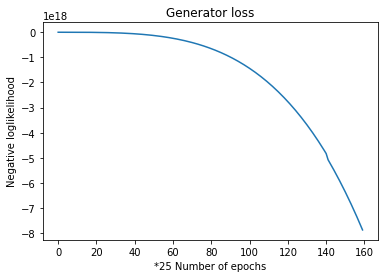

In [ ]:
plt.plot([n[0] for n in loss_history])
plt.xlabel('*25 Number of epochs')
plt.ylabel("Negative loglikelihood")
plt.title('Generator loss')


Text(0.5, 1.0, 'Discriminator loss')

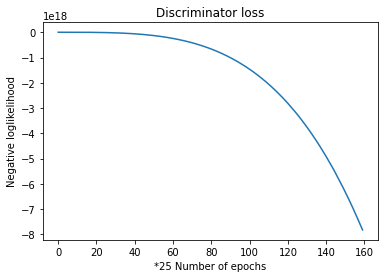

In [ ]:
plt.plot([n[1] for n in loss_list])
plt.xlabel('*25 Number of epochs')
plt.ylabel("Negative loglikelihood")
plt.title('Discriminator loss')


In [ ]:
torch.save(generator, "drive/MyDrive/assignment_2/generator_first_run.pt")
torch.save(discriminator, "drive/MyDrive/assignment_2/discriminator_first_run.pt")

In [ ]:
len(train_data)

88

In [ ]:
generator.eval()
train_data[0]

(tensor([[[0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.9686, 0.9765, 0.9647,  ..., 0.9255, 0.8275, 0.7804],
          [0.9412, 0.8902, 0.6824,  ..., 0.7529, 0.8118, 0.9020],
          [0.6863, 0.5765, 0.3961,  ..., 0.8118, 0.8745, 0.8314]]]),
 tensor([[[0.4471, 0.4471, 0.4510,  ..., 0.4902, 0.4902, 0.4902],
          [0.4471, 0.4471, 0.4510,  ..., 0.4902, 0.4902, 0.4902],
          [0.4471, 0.4471, 0.4510,  ..., 0.4902, 0.4902, 0.4902],
          ...,
          [0.3765, 0.3686, 0.3451,  ..., 0.7882, 0.7882, 0.7569],
          [0.3333, 0.2588, 0.1765,  ..., 0.7843, 0.7686, 0.8392],
          [0.1333, 0.0706, 0.0235,  ..., 0.6824, 0.6471, 0.6863]],
 
         [[0.8667, 0.8667, 0.8667,  ..., 0.8510, 0.8510, 0.8510],
          [0.8667, 0.8667, 0.8667,  ..., 0.8510, 0.8510, 0.8510],
          [0.8667, 0.8667, 0.8667,  ...,

In [ ]:
generator = torch.load('drive/MyDrive/assignment_2/generator_first_run.pt')


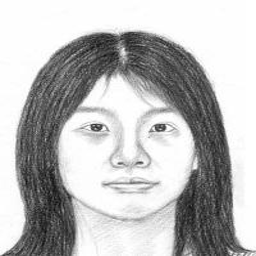

In [ ]:
generator.eval()
Image.open(train_data.train_sketches[0]).resize((DIM, DIM))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


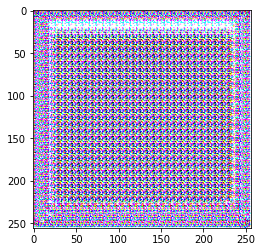

In [ ]:
plt.imshow(generator(train_data[30][0].view((1, 1, DIM, DIM)).to(device)).view((3, DIM, DIM)).permute(1, 2, 0).detach().cpu().numpy())